<h1 style="text-align:center; color:dark

<h1 style="text-align:center; color:darkgreen"> IBM Data Science Professional Certificate </h1>
<h2 style="text-align:center; color:darkgreen"> Capstone Project: Battle of Neighborhoods </h2> 
<a href="https://www.coursera.org/specializations/ibm-data-science-professional-certificate" target="_blank"><p style="text-align:center; font-size:8; color:darkgray"> Applied Data Science by Coursera/ IBM </p></a>


<br>

<img src="https://www.google.com/url?sa=i&source=images&cd=&cad=rja&uact=8&ved=2ahUKEwiy77_k_-jhAhXQzqQKHca9DfkQjRx6BAgBEAU&url=https%3A%2F%2Fwww.amazon.com%2FWall-Art-Prints-Toronto-Landscape%2Fdp%2FB07JHWJMSF&psig=AOvVaw2FMUPh42FBonkUcz-JLmXw&ust=1556204156505945" height=500 width=700>

<br>
<br>

### Jupyter Notebook (including all code)
PS. the report is provided separately!<br><br>

We will start by importing the libraries we will need to work in this Notebook. 
<br>

In [80]:
#importing all libraries

import numpy as np 
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json 
from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim
from bs4 import BeautifulSoup
import lxml.html as lh
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
!conda install -c conda-forge folium=0.5.0 --yes
import folium 
print('Folium installed')
print('Libraries imported.')

Solving environment: - 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::anaconda==5.3.1=py37_0
  - defaults/linux-64::astropy==3.0.4=py37h14c3975_0
  - defaults/linux-64::bkcharts==0.2=py37_0
  - defaults/linux-64::blaze==0.11.3=py37_0
  - defaults/linux-64::bokeh==0.13.0=py37_0
  - defaults/linux-64::bottleneck==1.2.1=py37h035aef0_1
  - defaults/linux-64::dask==0.19.1=py37_0
  - defaults/linux-64::datashape==0.5.4=py37_1
  - defaults/linux-64::mkl-service==1.1.2=py37h90e4bf4_5
  - defaults/linux-64::numba==0.39.0=py37h04863e7_0
  - defaults/linux-64::numexpr==2.6.8=py37hd89afb7_0
  - defaults/linux-64::odo==0.5.1=py37_0
  - defaults/linux-64::pytables==3.4.4=py37ha205bf6_0
  - defaults/linux-64::pytest-arraydiff==0.2=py37h39e3cac_0
  - defaults/linux-64::pytest-astropy==0.4.0=py37_0
  - defaults/linux-64::pytest-doctestplus==0.1.3=py37_0
  - defaults/linux-64::pywavelets==1.0.0=py37h

<br>

## Data acquiring and processing

<br>

### Web Scraping using Beautiful Soup
<br>

We will use web scraping to the following wikipedia page "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M" (we will try to retrieve the rows that contains data)

In [81]:
#Scraping Wikipedia

url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
r = requests.get(url)

soup = BeautifulSoup(r.content, 'html.parser')
table = soup.find('table')
trows = table.find_all('tr')
rows = []
for tr in trows:
    i = tr.find_all('td')
    if i:
        rows.append(i)        
lst = []
for row in rows:
    postalcode = row[0].text.rstrip()
    borough = row[1].text.rstrip()
    neighborhood = row[2].text.rstrip()
    if borough != 'Not assigned':
        if neighborhood == 'Not assigned':
            neighborhood = borough
        lst.append([postalcode, borough, neighborhood])
        
cols = ['PostalCode', 'Borough', 'Neighborhood']
df = pd.DataFrame(lst, columns=cols)
print(df.shape)

(211, 3)


In [82]:
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights


Note: the retrieved dataset contains data that are duplicate. So we will clean this by using *".groupby"* to keep the first Borough and *".join()"* the Neighborhoods

In [83]:
#Cleaning data

#groupby PostalCode, keep the first Borough and join() Neighborhoods
df = df.groupby('PostalCode').agg(
    {
        'Borough':'first', 
        'Neighborhood': ', '.join,}
    ).reset_index()

df.shape

(103, 3)

The size now looks fine. Let's run a test to see if we have the dataset how we wanted it to be.

In [84]:
df.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


Yes! that's fine.

In order to visualize the neighborhoods of the city of Toronto, we need the geospatial data of each neighborhoods. We have collected data from *http://cocl.us/Geospatial_data* and the population counts from *https://www.statcan.gc.ca* <br>
We have converted the *.csv* files into *pandas data frame*

In [85]:
#Clean and sort
#read the csv and put it into pandas data frame
dfgeo = pd.read_csv("Geospatial.csv")
dfgeo.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
df2 = pd.merge(df, dfgeo, on="PostalCode", how='left')
df2.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Population
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,66108
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,35626
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,46943
3,M1G,Scarborough,Woburn,43.770992,-79.216917,29690
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,24383


In [147]:
#df2: how many boroughs and neighborhoods are there?

print('The dataframe (2) has {} boroughs and {} neighborhoods.'.format(
        len(df2['Borough'].unique()),
        df2.shape[0]
    )
)

The dataframe (2) has 11 boroughs and 103 neighborhoods.


<h5> Geographical coordinates of Toronto </h5>

In [87]:
address = 'Toronto'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


##### Creating map of Toronto using latitude and longitude values

In [214]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df2['Latitude'], df2['Longitude'], df2['Borough'], df2['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='white',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Foursquare - set up

In [89]:
#Foursquare credentials
CLIENT_ID = 'FE2ISW0SIPV4KWSV5GPDWXQLWLOOHJPILFH20ZOSUK4XMOSY' # your Foursquare ID
CLIENT_SECRET = '4CLBWAVPR25MGWQXN4QYSY5RBO3B3WYTRN0K1J0BNUXC1K4Z' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

As described earlier, we will set the limit of the parameters: API call of each neighborhood and radius.

In [90]:
#set the limit
LIMIT = 100
radius = 700

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=FE2ISW0SIPV4KWSV5GPDWXQLWLOOHJPILFH20ZOSUK4XMOSY&client_secret=4CLBWAVPR25MGWQXN4QYSY5RBO3B3WYTRN0K1J0BNUXC1K4Z&v=20180605&ll=43.653963,-79.387207&radius=700&limit=100'

In [91]:
results = requests.get(url).json()
#results

In [92]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['reasons.count', 'reasons.items', 'referralId', 'venue.categories',
       'venue.id', 'venue.location.address', 'venue.location.cc',
       'venue.location.city', 'venue.location.country',
       'venue.location.crossStreet', 'venue.location.distance',
       'venue.location.formattedAddress', 'venue.location.labeledLatLngs',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.neighborhood', 'venue.location.postalCode',
       'venue.location.state', 'venue.name', 'venue.photos.count',
       'venue.photos.groups', 'venue.venuePage.id'],
      dtype='object')

Now that we have acquired the venues of each neighborhod, let's define a function to get the *venue names* with *venue categories*

In [93]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [94]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Downtown Toronto,"[{'id': '4f2a25ac4b909258e854f55f', 'name': 'N...",43.653232,-79.385296
1,Textile Museum of Canada,"[{'id': '4bf58dd8d48988d18f941735', 'name': 'A...",43.654396,-79.386500
2,Sansotei Ramen 三草亭,"[{'id': '55a59bace4b013909087cb24', 'name': 'R...",43.655157,-79.386501
3,Japango,"[{'id': '4bf58dd8d48988d1d2941735', 'name': 'S...",43.655268,-79.385165
4,Tsujiri,"[{'id': '4bf58dd8d48988d1dc931735', 'name': 'T...",43.655374,-79.385354


Well, that doesn't look optimal for further use! So we use *".apply()"* to get the type of the categories.

In [95]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Downtown Toronto,Neighborhood,43.653232,-79.385296
1,Textile Museum of Canada,Art Museum,43.654396,-79.386500
2,Sansotei Ramen 三草亭,Ramen Restaurant,43.655157,-79.386501
3,Japango,Sushi Restaurant,43.655268,-79.385165
4,Tsujiri,Tea Room,43.655374,-79.385354


Let's create a function to repeat the same process to all neighborhoods in the city of Toronto

In [96]:
#let's create a function to repeat the same process to all neighborhoods in Toronto, CA

def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [97]:
toronto_venues = getNearbyVenues(names=df2['Neighborhood'],
                                   latitudes=df2['Latitude'],
                                   longitudes=df2['Longitude']
                                  )

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, 

<br>
We will look at the size

In [144]:
print(toronto_venues.shape)

(3461, 7)


In [145]:
toronto_venues.groupby('Neighborhood').count().head(10)

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Agincourt,10,10,10,10,10,10
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",17,17,17,17,17,17
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",9,9,9,9,9,9
"Alderwood, Long Branch",11,11,11,11,11,11
"Bathurst Manor, Downsview North, Wilson Heights",21,21,21,21,21,21
Bayview Village,9,9,9,9,9,9
"Bedford Park, Lawrence Manor East",31,31,31,31,31,31
Berczy Park,100,100,100,100,100,100


How many unique categories are there?

In [146]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 319 uniques categories.


### One Hot Encoding

In [148]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Housing Development,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Rock Climbing Spot,Rock Club,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting G

In [149]:
toronto_onehot.shape

(3461, 319)

In [150]:
#here we group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head(10)

,Neighborhood,Yoga Studio,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Housing Development,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Rock Climbing Spot,Rock Club,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting G

##### New size after "one hot encoding"

In [151]:
#the new size

toronto_grouped.shape

(102, 319)

In [152]:
#save the data (!optional)

toronto_grouped.to_csv('toronto_grouped.csv', sep='\t')


**Let's find out each neighborhood along with the top 10 most common venues**

In [153]:
num_top_venues = 10

for hood in toronto_grouped['Neighborhood'][:5]:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
                 venue  freq
0          Coffee Shop  0.07
1                 Café  0.06
2           Steakhouse  0.04
3     Sushi Restaurant  0.04
4  American Restaurant  0.04
5            Gastropub  0.03
6           Restaurant  0.03
7                  Bar  0.03
8      Thai Restaurant  0.03
9              Theater  0.03


----Agincourt----
                 venue  freq
0  Shanghai Restaurant   0.1
1            Pool Hall   0.1
2      Badminton Court   0.1
3       Breakfast Spot   0.1
4          Coffee Shop   0.1
5       Sandwich Place   0.1
6       Clothing Store   0.1
7      Motorcycle Shop   0.1
8               Lounge   0.1
9         Skating Rink   0.1


----Agincourt North, L'Amoreaux East, Milliken, Steeles East----
                  venue  freq
0    Chinese Restaurant  0.18
1           Pizza Place  0.12
2              Pharmacy  0.12
3             BBQ Joint  0.12
4          Noodle House  0.06
5                   Gym  0.06
6      Malay Restaurant  0.06
7 

### Let's put it into pandas Dataframe

In [154]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [155]:
#create a new dataframe and display the top 10 venues for each neighborhood

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Sushi Restaurant,Steakhouse,American Restaurant,Gastropub,Restaurant,Thai Restaurant,Theater,Bar
1,Agincourt,Coffee Shop,Motorcycle Shop,Clothing Store,Lounge,Badminton Court,Pool Hall,Breakfast Spot,Shanghai Restaurant,Sandwich Place,Skating Rink
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Chinese Restaurant,Pharmacy,BBQ Joint,Pizza Place,Park,Noodle House,Caribbean Restaurant,Shop & Service,Fast Food Restaurant,Bakery
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,Hardware Store,Fried Chicken Joint,Pharmacy,Sandwich Place,Beer Store,Fast Food Restaurant,Pizza Place,Golf Driving Range,Empanada Restaurant
4,"Alderwood, Long Branch",Pizza Place,Coffee Shop,Pool,Convenience Store,Gas Station,Skating Rink,Pub,Pharmacy,Gym,Sandwich Place
5,"Bathurst Manor, Downsview North, Wilson Heights",Coffee Shop,Pizza Place,Frozen Yogurt Shop,Bank,Sushi Restaurant,Supermarket,Fast Food Restaurant,Bridal Shop,Shopping Mall,Diner
6,Bayview Village,Bank,Chinese Restaurant,Japanese Restaurant,Café,Grocery Store,Restaurant,Skating Rink,Skate Park,Doner Restaurant,Diner
7,"Bedford Park, Lawrence Manor East",Italian Restaurant,Coffee Shop,Fast Food Restaurant,Hardware Store,Pizza Place,Sushi Restaurant,Bakery,Sandwich Place,Butcher,Café
8,Berczy Park,Coffee Shop,Café,Hotel,Restaurant,Pub,Beer Bar,Park,Cocktail Bar,Art Gallery,Cheese Shop
9,"Birch Cliff, Cliffside West",Skating Rink,Bank,Café,Diner,Discount Store,General Entertainment,Thai Restaurant,Park,College Stadium,Eastern European Restaurant


<br>

## Clustering Neighborhoods
<br>

Determining the optimal number of clusters in a data set is a fundamental issue in partitioning clustering, such as **k-means clustering**, which requires the user to specify the number of clusters k to be generated.<br>

There are many methods to determine the optimal number. These methods include **direct methods** and **statistical testing methods**. <br>

In this project we will consider the direct methods. We will use **Elbow** method and **Average Silhouette** method.
<br>

In [109]:
# import libraries

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

##### Elbow Method

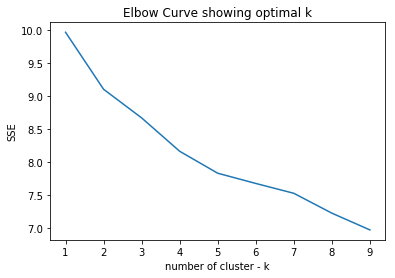

In [111]:
toronto_clustering = toronto_grouped.drop('Neighborhood', 1)
sse={}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(toronto_clustering)
    toronto_clustering['clusters'] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.title("Elbow Curve showing optimal k")
plt.xlabel("number of cluster - k")
plt.ylabel("SSE")
plt.show()

##### Average Silhouette Method

For 3  Clusters  the average silhouette_score is : 0.6546297506035555
For 5  Clusters  the average silhouette_score is : 0.6175563811476819
For 7  Clusters  the average silhouette_score is : 0.6540577581832933
For 10  Clusters  the average silhouette_score is : 0.5827492526695652


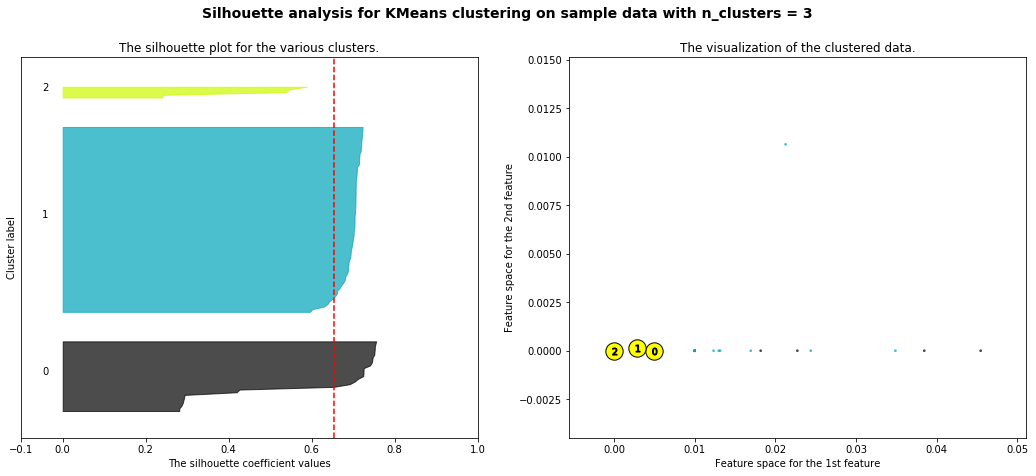

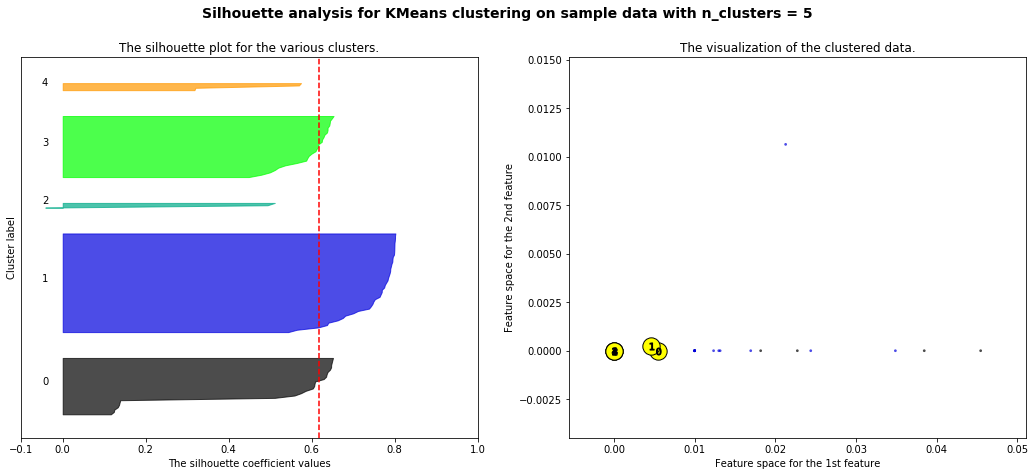

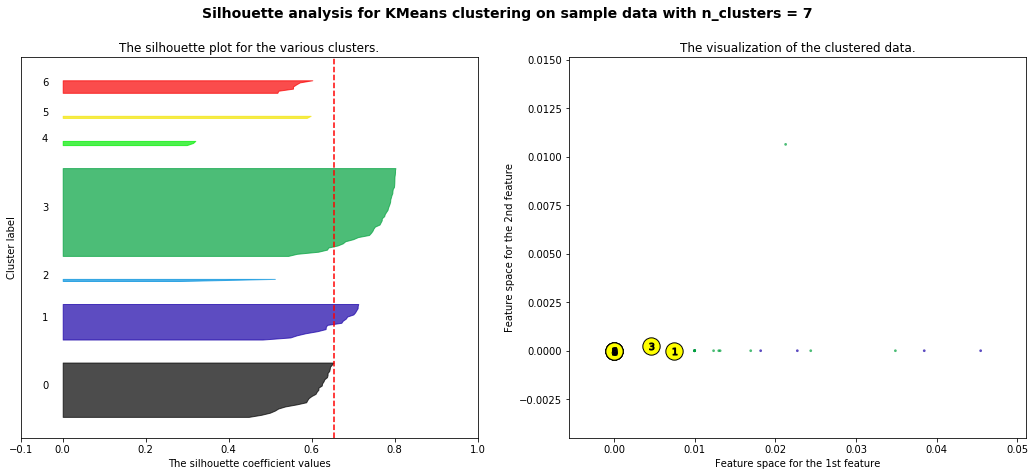

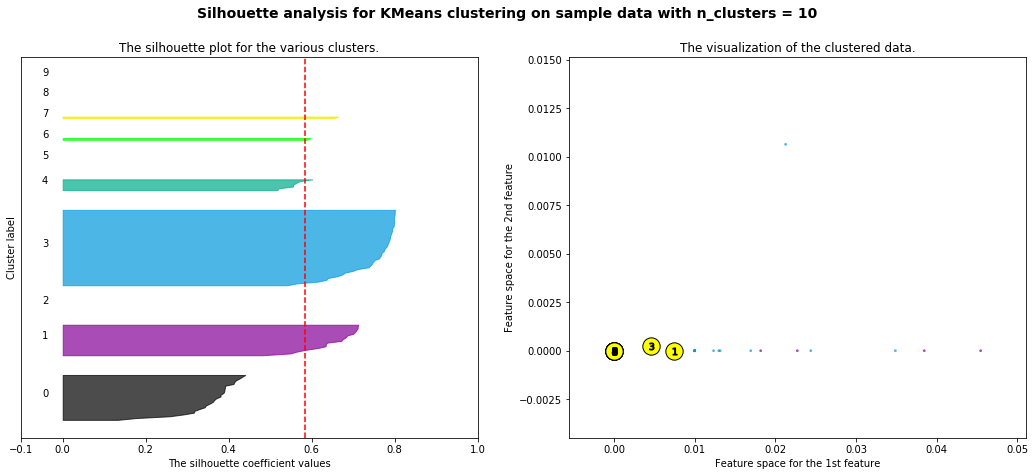

In [112]:
from sklearn.metrics import silhouette_samples, silhouette_score

range_n_clusters=[3,5,7,10]
for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(toronto_clustering) + (n_clusters + 1) * 10])
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(toronto_clustering)
    silhouette_avg = silhouette_score(toronto_clustering, cluster_labels)
    print("For", n_clusters, " Clusters  "
          "the average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(toronto_clustering, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color1 = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color1, edgecolor=color1, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    colors2 = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(toronto_clustering.iloc[:, 0], toronto_clustering.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors2, edgecolor='k')
    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="yellow", alpha=1, s=300, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

<br>
<br>

In [200]:
# set number of clusters
kclusters = 5

toronto_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([4, 4, 0, 0, 0, 4, 0, 4, 4, 4, 0, 4, 4, 1, 4, 4, 0, 4, 4, 4, 4, 4,
       4, 4, 0, 0, 0, 4, 4, 0, 4, 0, 4, 4, 4, 4, 4, 0, 0, 0, 4, 4, 4, 4,
       4, 4, 1, 0, 0, 4, 4, 4, 4, 4, 4, 0, 4, 3, 4, 0, 0, 4, 0, 4, 1, 4,
       4, 0, 1, 1, 4, 0, 4, 4, 1, 4, 1, 0, 4, 4, 4, 0, 2, 4, 4, 4, 4, 4,
       4, 4, 0, 4, 4, 4, 0, 4, 4, 0, 1, 0, 1, 1], dtype=int32)

In [114]:
k_means_cluster_centers = kmeans.cluster_centers_
#k_means_cluster_centers

##### Adding the cluster labels

In [157]:
# add clustering labels

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df2
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,66108,4.0,Fast Food Restaurant,Coffee Shop,Spa,Bus Station,Hobby Shop,Construction & Landscaping,Women's Store,Donut Shop,Diner,Discount Store
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,35626,4.0,Breakfast Spot,Bar,Burger Joint,Dumpling Restaurant,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,46943,0.0,Pizza Place,Fast Food Restaurant,Grocery Store,Breakfast Spot,Moving Target,Electronics Store,Fried Chicken Joint,Rental Car Location,Thrift / Vintage Store,Greek Restaurant
3,M1G,Scarborough,Woburn,43.770992,-79.216917,29690,1.0,Park,Coffee Shop,Convenience Store,Business Service,Event Space,Ethiopian Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,24383,4.0,Coffee Shop,Indian Restaurant,Bakery,Thai Restaurant,Gym / Fitness Center,Fried Chicken Joint,Flower Shop,Chinese Restaurant,Rental Car Location,Caribbean Restaurant


In [158]:
toronto_merged['Cluster Labels'] = (
    toronto_merged['Cluster Labels'].fillna(0)
    .astype(int)
    .astype(object)
    .where(toronto_merged['Cluster Labels'].notnull())
)
toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,66108,4,Fast Food Restaurant,Coffee Shop,Spa,Bus Station,Hobby Shop,Construction & Landscaping,Women's Store,Donut Shop,Diner,Discount Store
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,35626,4,Breakfast Spot,Bar,Burger Joint,Dumpling Restaurant,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,46943,0,Pizza Place,Fast Food Restaurant,Grocery Store,Breakfast Spot,Moving Target,Electronics Store,Fried Chicken Joint,Rental Car Location,Thrift / Vintage Store,Greek Restaurant
3,M1G,Scarborough,Woburn,43.770992,-79.216917,29690,1,Park,Coffee Shop,Convenience Store,Business Service,Event Space,Ethiopian Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,24383,4,Coffee Shop,Indian Restaurant,Bakery,Thai Restaurant,Gym / Fitness Center,Fried Chicken Joint,Flower Shop,Chinese Restaurant,Rental Car Location,Caribbean Restaurant


In [159]:
toronto_merged.shape

(103, 17)

#### Creating map of neighborhoods with their cluster labels

In [205]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters



In [ ]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine the clusters

In [163]:
#Examine
#Cluster 1

df3=toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
df3

,Borough,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Scarborough,46943,0,Pizza Place,Fast Food Restaurant,Grocery Store,Breakfast Spot,Moving Target,Electronics Store,Fried Chicken Joint,Rental Car Location,Thrift / Vintage Store,Greek Restaurant
5,Scarborough,36699,0,Fast Food Restaurant,Women's Store,Convenience Store,Coffee Shop,Pizza Place,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run
8,Scarborough,22913,0,Furniture / Home Store,Chinese Restaurant,Wings Joint,Burger Joint,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant
11,Scarborough,29858,0,Pizza Place,Burger Joint,Coffee Shop,Middle Eastern Restaurant,Seafood Restaurant,Bakery,Korean Restaurant,Fish Market,Intersection,Convenience Store
13,Scarborough,34588,0,Pharmacy,Shopping Mall,Pizza Place,Chinese Restaurant,Italian Restaurant,Sandwich Place,Bus Stop,Thai Restaurant,Fried Chicken Joint,Seafood Restaurant
14,Scarborough,54680,0,Chinese Restaurant,Pharmacy,BBQ Joint,Pizza Place,Park,Noodle House,Caribbean Restaurant,Shop & Service,Fast Food Restaurant,Bakery
15,Scarborough,48471,0,Fast Food Restaurant,Grocery Store,Chinese Restaurant,Pharmacy,Indian Restaurant,Burger Joint,Cosmetics Shop,American Restaurant,Other Great Outdoors,Sandwich Place
19,North York,23852,0,Bank,Chinese Restaurant,Japanese Restaurant,Café,Grocery Store,Restaurant,Skating Rink,Skate Park,Doner Restaurant,Diner
24,North York,40792,0,Pizza Place,Coffee Shop,Pharmacy,Grocery Store,Butcher,Doner Restaurant,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner
31,North York,17339,0,Pizza Place,Moving Target,Grocery Store,Vietnamese Restaurant,Park,Shopping Mall,Bank,Women's Store,Dive Bar,Dessert Shop


In [164]:
#Examine
#Cluster 2

df4=toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
df4

,Borough,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Scarborough,29690,1,Park,Coffee Shop,Convenience Store,Business Service,Event Space,Ethiopian Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
21,North York,32320,1,Park,Coffee Shop,Bus Line,Trail,Women's Store,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar
23,North York,7843,1,Park,Tennis Court,Intersection,Pet Store,Bank,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar
25,North York,34615,1,Park,Fast Food Restaurant,Pet Store,Burger Joint,Food & Drink Shop,Women's Store,Donut Shop,Diner,Discount Store,Dive Bar
30,North York,5997,1,Sandwich Place,Coffee Shop,Airport,Park,Donut Shop,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar
36,East York,46866,1,Park,Pharmacy,Skating Rink,Asian Restaurant,Bus Stop,Bus Line,Curling Ice,Cosmetics Shop,Athletics & Sports,Video Store
44,Central Toronto,15330,1,Bus Line,Park,Business Service,Swim School,Women's Store,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar
48,Central Toronto,10463,1,Park,Thai Restaurant,Gym / Fitness Center,Gym,Grocery Store,Playground,Bank,Women's Store,Dive Bar,Design Studio
50,Downtown Toronto,14561,1,Park,Playground,Gym / Fitness Center,Trail,Doner Restaurant,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
64,Central Toronto,19423,1,Sushi Restaurant,Gym / Fitness Center,Park,Jewelry Store,Trail,Women's Store,Dim Sum Restaurant,Diner,Discount Store,Dive Bar


In [165]:
#Examine
#Cluster 3

df5=toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
df5

,Borough,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,North York,11717,2,Martial Arts Dojo,Cafeteria,Falafel Restaurant,Exhibit,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run


In [166]:
#Examine
#Cluster 4

df6=toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
df6

,Borough,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
96,North York,11950,3,Bakery,Pizza Place,Empanada Restaurant,Women's Store,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run


In [167]:
#Examine
#Cluster 5

df7=toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
df7

,Borough,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,66108,4,Fast Food Restaurant,Coffee Shop,Spa,Bus Station,Hobby Shop,Construction & Landscaping,Women's Store,Donut Shop,Diner,Discount Store
1,Scarborough,35626,4,Breakfast Spot,Bar,Burger Joint,Dumpling Restaurant,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore
4,Scarborough,24383,4,Coffee Shop,Indian Restaurant,Bakery,Thai Restaurant,Gym / Fitness Center,Fried Chicken Joint,Flower Shop,Chinese Restaurant,Rental Car Location,Caribbean Restaurant
6,Scarborough,48434,4,Discount Store,Coffee Shop,Sandwich Place,Light Rail Station,Department Store,Convenience Store,Chinese Restaurant,Intersection,Grocery Store,Metro Station
7,Scarborough,35081,4,Intersection,Diner,Coffee Shop,Bus Line,Bakery,Bus Station,Fast Food Restaurant,Park,Metro Station,Soccer Field
9,Scarborough,22136,4,Skating Rink,Bank,Café,Diner,Discount Store,General Entertainment,Thai Restaurant,Park,College Stadium,Eastern European Restaurant
10,Scarborough,45571,4,Electronics Store,Indian Restaurant,Fast Food Restaurant,Wings Joint,Gym / Fitness Center,Vietnamese Restaurant,Coffee Shop,Pet Store,Bakery,Chinese Restaurant
12,Scarborough,37769,4,Coffee Shop,Motorcycle Shop,Clothing Store,Lounge,Badminton Court,Pool Hall,Breakfast Spot,Shanghai Restaurant,Sandwich Place,Skating Rink
17,North York,24497,4,Fast Food Restaurant,Bakery,Diner,Housing Development,Chinese Restaurant,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
18,North York,58293,4,Clothing Store,Fast Food Restaurant,Coffee Shop,Baseball Field,Women's Store,Sandwich Place,Restaurant,Park,Japanese Restaurant,Electronics Store


#### Creating the table containing all boroughs with cluster label for comparison

In [168]:
#creating cluster table
cluster_t=pd.DataFrame({"Cluster1":df3["Borough"],
                      "Cluster2":df4["Borough"],
                      "Cluster3":df5["Borough"],
                      "Cluster4":df6["Borough"],
                      "Cluster5":df7["Borough"]
                      })

In [169]:
cluster_t = cluster_t.replace(np.nan, '', regex=True)
cluster_t

,Cluster1,Cluster2,Cluster3,Cluster4,Cluster5
0,,,,,Scarborough
1,,,,,Scarborough
2,Scarborough,,,,
3,,Scarborough,,,
4,,,,,Scarborough
5,Scarborough,,,,
6,,,,,Scarborough
7,,,,,Scarborough
8,Scarborough,,,,
9,,,,,Scarborough


In [170]:
new_toronto=toronto_merged.set_index("Neighborhood",drop=True)
new_toronto.head(10)

,PostalCode,Borough,Latitude,Longitude,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood,,,,,,,,,,,,,,,,
"Rouge, Malvern",M1B,Scarborough,43.806686,-79.194353,66108,4,Fast Food Restaurant,Coffee Shop,Spa,Bus Station,Hobby Shop,Construction & Landscaping,Women's Store,Donut Shop,Diner,Discount Store
"Highland Creek, Rouge Hill, Port Union",M1C,Scarborough,43.784535,-79.160497,35626,4,Breakfast Spot,Bar,Burger Joint,Dumpling Restaurant,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore
"Guildwood, Morningside, West Hill",M1E,Scarborough,43.763573,-79.188711,46943,0,Pizza Place,Fast Food Restaurant,Grocery Store,Breakfast Spot,Moving Target,Electronics Store,Fried Chicken Joint,Rental Car Location,Thrift / Vintage Store,Greek Restaurant
Woburn,M1G,Scarborough,43.770992,-79.216917,29690,1,Park,Coffee Shop,Convenience Store,Business Service,Event Space,Ethiopian Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
Cedarbrae,M1H,Scarborough,43.773136,-79.239476,24383,4,Coffee Shop,Indian Restaurant,Bakery,Thai Restaurant,Gym / Fitness Center,Fried Chicken Joint,Flower Shop,Chinese Restaurant,Rental Car Location,Caribbean Restaurant
Scarborough Village,M1J,Scarborough,43.744734,-79.239476,36699,0,Fast Food Restaurant,Women's Store,Convenience Store,Coffee Shop,Pizza Place,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run
"East Birchmount Park, Ionview, Kennedy Park",M1K,Scarborough,43.727929,-79.262029,48434,4,Discount Store,Coffee Shop,Sandwich Place,Light Rail Station,Department Store,Convenience Store,Chinese Restaurant,Intersection,Grocery Store,Metro Station
"Clairlea, Golden Mile, Oakridge",M1L,Scarborough,43.711112,-79.284577,35081,4,Intersection,Diner,Coffee Shop,Bus Line,Bakery,Bus Station,Fast Food Restaurant,Park,Metro Station,Soccer Field
"Cliffcrest, Cliffside, Scarborough Village West",M1M,Scarborough,43.716316,-79.239476,22913,0,Furniture / Home Store,Chinese Restaurant,Wings Joint,Burger Joint,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant


In [171]:
new_toronto.tail(10)

,PostalCode,Borough,Latitude,Longitude,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood,,,,,,,,,,,,,,,,
Islington Avenue,M9A,Etobicoke,43.667856,-79.532242,35594,0,Pharmacy,Playground,Grocery Store,Café,Park,Shopping Mall,Bank,Skating Rink,Women's Store,Dive Bar
"Cloverdale, Islington, Martin Grove, Princess Gardens, West Deane Park",M9B,Etobicoke,43.650943,-79.554724,32400,0,Pizza Place,Theater,Convenience Store,Bank,Ethiopian Restaurant,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
"Bloordale Gardens, Eringate, Markland Wood, Old Burnhamthorpe",M9C,Etobicoke,43.643515,-79.577201,38291,0,Park,Pizza Place,Pharmacy,Beer Store,Electronics Store,Liquor Store,Café,Shopping Plaza,Convenience Store,Dog Run
Humber Summit,M9L,North York,43.756303,-79.565963,11950,3,Bakery,Pizza Place,Empanada Restaurant,Women's Store,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run
"Emery, Humberlea",M9M,North York,43.724766,-79.532242,22263,4,Convenience Store,Italian Restaurant,Discount Store,Baseball Field,Dumpling Restaurant,Diner,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
Weston,M9N,York,43.706876,-79.518188,25074,4,Diner,Fried Chicken Joint,Pharmacy,Breakfast Spot,Women's Store,Donut Shop,Dim Sum Restaurant,Discount Store,Dive Bar,Dog Run
Westmount,M9P,Etobicoke,43.696319,-79.532242,20874,0,Pizza Place,Golf Course,Ice Cream Shop,Discount Store,Supermarket,Chinese Restaurant,Sandwich Place,Middle Eastern Restaurant,Intersection,Golf Driving Range
"Kingsview Village, Martin Grove Gardens, Richview Gardens, St. Phillips",M9R,Etobicoke,43.688905,-79.554724,33743,0,Coffee Shop,American Restaurant,Pizza Place,Chinese Restaurant,Sandwich Place,Bus Line,Mobile Phone Shop,Shopping Mall,Beer Store,Supermarket
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",M9V,Etobicoke,43.739416,-79.588437,55959,0,Grocery Store,Hardware Store,Fried Chicken Joint,Pharmacy,Sandwich Place,Beer Store,Fast Food Restaurant,Pizza Place,Golf Driving Range,Empanada Restaurant


<br>

## Compare the neighborhoods

In [172]:
Nbd1=input("Enter the Neighborhood: ")

Enter the Neighborhood:  Northwest


In [175]:
Nbd2=input("Enter the Neighborhood: ")

Enter the Neighborhood:  Weston


In [176]:
venue_comparison=new_toronto.loc[[Nbd1,Nbd2]].T
venue_comparison

Neighborhood,Northwest,Weston
PostalCode,M9W,M9N
Borough,Etobicoke,York
Latitude,43.7067,43.7069
Longitude,-79.5941,-79.5182
Population,40684,25074
Cluster Labels,0,4
1st Most Common Venue,Rental Car Location,Diner
2nd Most Common Venue,Home Service,Fried Chicken Joint
3rd Most Common Venue,Drugstore,Pharmacy
4th Most Common Venue,Hotel,Breakfast Spot


In [177]:
Nbd1=input("Enter the Neighborhood: ")

Enter the Neighborhood:  Rosedale


In [178]:
Nbd2=input("Enter the Neighborhood: ")

Enter the Neighborhood:  Woburn


In [179]:
Nbd3=input("Enter the Neighborhood: ")

Enter the Neighborhood:  Humber Summit


In [180]:
venue_comparison=new_toronto.loc[[Nbd1,Nbd2,Nbd3]].T
venue_comparison

Neighborhood,Rosedale,Woburn,Humber Summit
PostalCode,M4W,M1G,M9L
Borough,Downtown Toronto,Scarborough,North York
Latitude,43.6796,43.771,43.7563
Longitude,-79.3775,-79.2169,-79.566
Population,14561,29690,11950
Cluster Labels,1,1,3
1st Most Common Venue,Park,Park,Bakery
2nd Most Common Venue,Playground,Coffee Shop,Pizza Place
3rd Most Common Venue,Gym / Fitness Center,Convenience Store,Empanada Restaurant
4th Most Common Venue,Trail,Business Service,Women's Store


<br>
<br>

In [208]:
!pip install emoji --upgrade

    100% |████████████████████████████████| 51kB 9.0MB/s 


In [213]:
import emoji

print(emoji.emojize('Thanks :thumbsup:', use_aliases=True))


Thanks 👍
